<a href="https://colab.research.google.com/github/elfinlkdd/practice-GAN/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import keras
print('Keras:', keras.__version__)
import tensorflow as tf
print('Tensorflow:', tf.__version__)
import sys
print('Python:', sys.version)

tf.compat.v1.disable_eager_execution() #因tf版本問題，關閉eager_execution避免vae.fit()產生錯誤

Keras: 2.13.1
Tensorflow: 2.13.0
Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
# GANs In Action
# Chapter 2: Autoencoder
# https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-2/Chapter_2_Autoencoder.ipynb


from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [ ]:
# defining the key parameters 超參數設定

batch_size = 100
original_dim = 784 # 28*28=784 (MNIST的影像高度*寬度)
latent_dim = 2 # 潛在空間的維度
intermediate_dim = 256 #中間層的維度
epochs = 50
epsilon_std = 1.0

In [ ]:
# Define sampling helper function. 建立取樣函數

def sampling(args: tuple):
    # we grab the variables from the tuple`
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# z_mean 平均值
# z_log_var 對異變數(var)取自然對數(ln(var))，exp(z_log_var/2)為計算之標準差(sqrt(var))

In [ ]:
# Defining the encoder

# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 encoding (Dense)            (None, 256)                  200960    ['input[0][0]']               
                                                                                                  
 mean (Dense)                (None, 2)                    514       ['encoding[0][0]']            
                                                                                                  
 log-variance (Dense)        (None, 2)                    514       ['encoding[0][0]']            
                                                                                            

In [ ]:
# Defining the decoder

# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# let's define the Variational Autoencoder (VAE)
# We use the encoder and decoder objects names from above.

# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])  #取encoder最後一個(索引2 index2)輸出做為decoder的輸入
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
Model??

In [ ]:
# Define the losses and run the model!
# We touch on KL loss and the cross-entropy loss (xent_loss) throughout the book, but these do not need to be familiar terms, as long as you understand the notion of a loss in machine learning.

def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor, z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum( 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Let's load and clean the only dataset there is, apparently: MNIST.

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255. #資料正規化(0~1)
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
print(f'訓練資料總筆數為 {len(x_train)} 筆資料')
print(f'測試資料總筆數為 {len(x_test)} 筆資料')

訓練資料總筆數為 60000 筆資料
測試資料總筆數為 10000 筆資料


In [ ]:
# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()

In [ ]:
# vae.compile(run_eagerly=True)

In [ ]:
vae.fit(x_train, x_train,
    shuffle=True, # 資料隨機重排
    epochs=epochs, batch_size=batch_size,
    validation_data=(x_test, x_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
59900/60000 [============================>.] - ETA: 0s - loss: 190.8366

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 11s 180us/sample - loss: 190.8190 - val_loss: 172.1173
Epoch 2/50
60000/60000 [==============================] - 10s 166us/sample - loss: 169.8965 - val_loss: 168.5965
Epoch 3/50
60000/60000 [==============================] - 9s 155us/sample - loss: 166.4646 - val_loss: 165.4124
Epoch 4/50
60000/60000 [==============================] - 9s 156us/sample - loss: 164.1788 - val_loss: 163.3827
Epoch 5/50
60000/60000 [==============================] - 10s 173us/sample - loss: 162.3995 - val_loss: 162.0727
Epoch 6/50
60000/60000 [==============================] - 10s 172us/sample - loss: 160.9876 - val_loss: 160.5181
Epoch 7/50
60000/60000 [==============================] - 15s 252us/sample - loss: 159.8682 - val_loss: 159.9094
Epoch 8/50
60000/60000 [==============================] - 12s 201us/sample - loss: 158.9062 - val_loss: 158.9192
Epoch 9/50
60000/60000 [==============================] - 14s 227us/sample - loss: 158.0454 - val_loss: 158.3

# 新增區段

# 新增區段

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


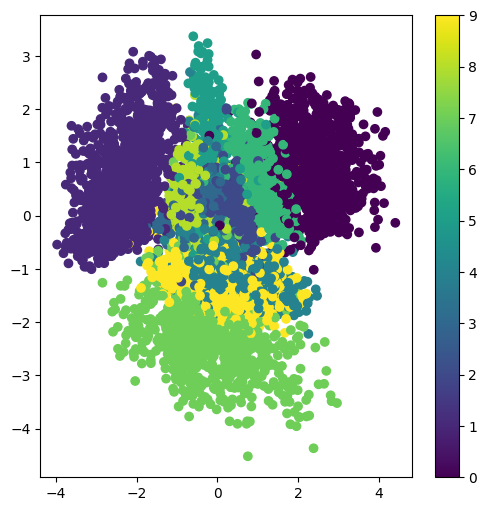

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

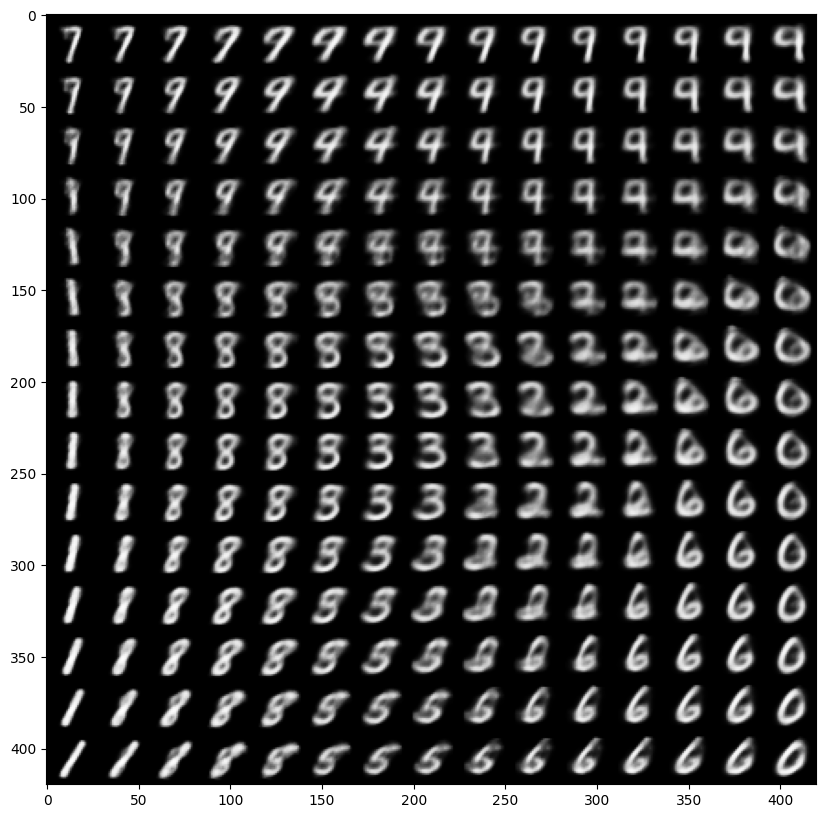

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()